## Import Libraries

In [1]:
# Data Analysis      
import pandas as pd          # data analysis library for handling structured data             
import numpy as np           # mathematical library for working with numerical data
import os, sys

# from metrics import *
# Add the previous directory to sys.path
sys.path.append(os.path.abspath('../'))

# Now you can import the metrics module
from metrics import *
import os 

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import missingno as msno    #visualize missing data
from sklearn.metrics import mean_squared_error, r2_score 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000) 


# Function to filter out LightGBM warnings
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings


In [2]:
root_dir = r"C:\Users\pault\OneDrive - University of Oklahoma\GRA - Bio-Manufacturing\1. ML-Cytovance-OU-Research"
os.chdir(root_dir)

## Preprocessing

> Drop invariant columns

In [3]:
# drop invariant columns 
def drop_invariant_columns(df):
    """
    This function takes a list of DataFrames and drops specified invariant columns from each DataFrame.

    Parameters:
    experiment_data (list): List of pandas DataFrames.
    invariant_cols (list): List of column names to be dropped from each DataFrame.

    Returns:
    list: A new list of DataFrames with invariant columns dropped.
    """
    invariant_cols = ['input_vessel_type',	'input_vessel_volume',	'input_vessel_name',	'input_agitation_rpm',	'input_DO_%',	
                  'input_pH_setpoint',	'input_gas_flow',	'input_air_%',	'input_O2',	'input_Temp_c',	'input_media_type',	
                  'input_feed_type',	'input_glucose_limit']
    

    # Create a copy of the DataFrame to avoid modifying the original data.
    updated_df = df.drop(columns=invariant_cols, axis=1)
    return updated_df




> Missing Value Imputation

In [4]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor    

def convert_WCW_zero(df):
    df['output_WCW_gl'] = df.apply(lambda row: 0 if row['input_Timepoint (hr)'] in [0,1, 2] else row['output_WCW_gl'], axis=1)
    # df['output_WCW_gl'] = df.apply(lambda row: 0 if row.name in [pd.Timestamp("2024-01-01 00:00:00"), pd.Timestamp("2024-01-01 01:00:00"), pd.Timestamp("2024-01-01 02:00:00")] else row['output_WCW_gl'], axis=1)
    return df


def impute_missing_values_iteratively(X_a, exclude=None):
    # Convert specific values to zero based on conditions
    X_a = convert_WCW_zero(X_a)
    X = X_a.copy()

    # Normalize the exclude parameter to be a list if it's not None or already a list
    if exclude is not None and not isinstance(exclude, list):
        exclude = [exclude]

    for col in X.columns:
        # Check if column is excluded or if it's 'input_Timepoint (hr)'
        if exclude is not None and col in exclude:
            continue

        # Process columns that are not excluded and meet the conditions
        if X[col].isnull().any() and X[col].dtype == 'object' and col != 'input_Timepoint (hr)':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100, random_state=0),  # the estimator to predict the NA
        initial_strategy='mean',  # how will NA be imputed in step 1
        max_iter=10,  # number of cycles
        imputation_order='ascending',  # the order in which to impute the variables
        n_nearest_features=None,  # whether to limit the number of predictors
        skip_complete=True,  # whether to ignore variables without NA
        random_state=0,)

    # Select columns that are now either originally numeric or successfully converted from object
    numeric_cols = [col for col in X.select_dtypes(include=['number']).columns if col not in exclude] if exclude is not None else X.select_dtypes(include=['number']).columns

    # Impute missing values only in the selected numeric columns that are not excluded
    X_imputed = imputer.fit_transform(X[numeric_cols])
    X_a[numeric_cols] = X_imputed

    return X_a 

> Scale and Concat

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Use StandardScaler for this
scale_cols = ['output_WCW_gl', 'output_agitation', 'output_air_%', 'output_D0_%', 'output_gasflow', 'output_O2', 'output_Ph', 
              'output_feed_%', 'output_feed', 'output_Temp', 'output_glycerol_gl', 
              'output_glucose_gl', 'output_acetate_mmol_l', 'output_phosphate_mmol_l']

def scale_and_concat(X, columns_to_transform = scale_cols, train = False, scaler = None):
    """
    Scales selected columns in a DataFrame using StandardScaler and concatenates them with the rest of the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns_to_transform (list): List of column names to be scaled.

    Returns:
        pandas.DataFrame: The concatenated DataFrame with scaled columns.
    """
    
    # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns_to_transform if col in X.columns]
    
    if train == True:
        # scaler = MinMaxScaler() # Initialize the scaler 
        scaler = StandardScaler()   # Initialize the scaler
        scaler.fit(X[valid_columns])  # Fit only on the training set
    else:
        scaler = scaler

    # Create a copy of the original DataFrame
    df_concatenated = X.copy()

    # Scale the selected columns
    scaled_columns = scaler.transform(X[valid_columns])

    # Create a DataFrame with the scaled columns
    df_scaled = pd.DataFrame(scaled_columns, columns=valid_columns, index=X.index)
            
    # Concatenate the scaled columns with the rest of the DataFrame
    df_concatenated = pd.concat([df_concatenated.drop(columns=valid_columns, axis = 1), df_scaled], axis=1)

    if train == True:
        return df_concatenated, scaler
    else:
        return df_concatenated
    



## Building the Model

> Titer Value imputation

In [6]:

import random 


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


def load_data(batch_names, num_impute = len(experiment_names), fraction_impute=0.8):  # Add fraction_impute parameter
    df_list = []
    impute_batches = np.random.choice(batch_names, size=num_impute, replace=False) 
    for b_name in batch_names:
        df = pd.read_csv(f"titer/data/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        
        # Find the first point where 'output_phosphate_mmol_l' <= 5
        condition_met_idx = df[df['output_phosphate_mmol_l'] <= 5].index.min()
        df['original_titer'] = df['output_titre_µgl'].copy()  # this copies the original titer for use in plotting 
        
        # Check if such a point exists
        if pd.notnull(condition_met_idx) and condition_met_idx > 1:
            # Calculate the index two rows up from the found point
            start_idx = max(condition_met_idx - 2, 0) 
            # Set 'output_titre_µgl' to 0.0 from start_idx to the beginning of the dataset
            df.loc[:start_idx, 'output_titre_µgl'] = 0.0
            
        # Find the last index with 'output_titre_µgl' == 0.0
        last_zero_idx = df[df['output_titre_µgl'] == 0.0].index.max() 

        # Determine the last non-NaN value or use the threshold
        if pd.isnull(df['output_titre_µgl'].iloc[-1]):
            final_value = random.uniform(0.3, 2.2)  # Threshold value if the last value is NaN
        else:
            final_value = df['output_titre_µgl'].dropna().iloc[-1]  # Last non-NaN value

        # Define the start and end indices for filling
        start_i = last_zero_idx + 1 if pd.notnull(last_zero_idx) else 0
        end_i = df.index.max() - 1  # Exclude the last time point

        # Apply the exponential function to fill missing values
        num_points = end_i - start_i + 1
        exp_values = np.linspace(0, 1, num_points)
        exp_values = final_value * (np.exp(exp_values) - 1) / (np.exp(1) - 1)  # Normalized exponential

        # Randomly select 60% of the indices to impute
        num_impute_points = int(num_points * fraction_impute)
        indices_to_impute = sorted(random.sample(range(start_i, end_i + 1), num_impute_points))

        for i, val in zip(indices_to_impute, exp_values[:num_impute_points]):
            if b_name in impute_batches:
                df.loc[i, 'output_titre_µgl'] = val
                df['input_batch'] = b_name

        # Set the final value
        if pd.isnull(df.loc[end_i + 1, 'output_titre_µgl']):
            df.loc[end_i + 1, 'output_titre_µgl'] = final_value

        df_list.append(df)
        
    return df_list 


def concatenate_impute_split(experiment_names):
    
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data, exclude = ['output_titre_µgl', 'input_batch', 'original_titer'])  # Impute missing values iteratively to avoid over-fitting on the test set

    # Split the data back into the original batches using the 'batch' column and return as a list
    # batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    batched_dataframes_list = [group for _, group in full_data_inputed.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def titer_imputation(experiment_names):
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Trial and Error: scale and cocatenate the dataset
    dataset = pd.concat(df_batch_list, ignore_index=True)

    return dataset



dataset = titer_imputation(experiment_names)

In [7]:
dataset

,input_Timepoint (hr),output_OD600,output_WCW_gl,output_agitation,output_air_%,output_D0_%,output_gasflow,output_O2,output_Ph,output_feed_%,output_feed,output_Temp,output_glycerol_gl,output_glucose_gl,output_acetate_mmol_l,output_phosphate_mmol_l,output_titre_µgl,batch,original_titer,input_batch
0,0.0,0.353000,0.000,1185.440000,100.000000,96.810000,5.010000,0.000000,6.910000,0.00,0.00000,30.19,6.4300,0.243000,1.9500,18.0000,0.000000,exp_210623_1,NaN,exp_210623_1
1,2.0,0.547000,0.000,1185.320000,100.000000,97.950000,5.000000,0.000000,6.775341,0.00,0.00000,29.99,5.2310,0.181900,3.7795,21.8014,0.000000,exp_210623_1,NaN,exp_210623_1
2,4.0,1.590000,0.000,1185.220000,100.000000,94.600000,5.000000,0.000000,6.850000,0.00,0.00000,30.01,6.4305,-0.004392,9.5241,27.5919,0.000000,exp_210623_1,NaN,exp_210623_1
3,6.0,4.460000,56.805,1184.830000,100.000000,82.450000,5.000000,0.000000,6.780000,0.00,0.00000,30.04,4.0480,-0.005319,15.6948,25.3705,0.000000,exp_210623_1,NaN,exp_210623_1
4,8.0,11.320000,51.770,1184.500000,100.000000,66.110000,5.000000,0.000000,6.710000,0.00,0.00000,29.99,0.0000,0.000000,15.6100,14.4700,0.000000,exp_210623_1,NaN,exp_210623_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,32.0,83.600000,207.500,1184.912964,99.576492,40.890980,4.793379,0.422386,6.194422,10.60,0.36040,25.99,0.2718,19.202700,4.0200,-0.0100,0.388978,exp_220822_4,NaN,exp_220822_4
680,36.0,87.400000,208.500,1184.800049,99.456673,40.179340,4.711772,0.543087,6.226009,9.01,0.30634,26.00,0.0097,18.399210,2.7800,-0.0200,0.560350,exp_220822_4,NaN,exp_220822_4
681,40.0,93.266667,217.500,1184.574951,99.654694,40.592091,4.850256,0.344494,6.214839,7.66,0.26044,26.01,0.1204,16.133740,4.1000,-0.0300,NaN,exp_220822_4,NaN,exp_220822_4
682,44.0,93.400000,216.500,1185.463989,99.543571,37.069462,4.800520,0.463291,6.221002,6.32,0.21488,25.98,0.0099,11.673240,4.8400,-0.1100,0.758038,exp_220822_4,NaN,exp_220822_4


> Particle Filter

In [8]:
# Control variables
    # Feed Type --> not in the dataset since it is invariant 
    # output_Ph (pH)
    # output_Temp (Temperature)
    # output_D0_% (Dissolved Oxygen Percentage)
    # Induction OD/Feed OD --> not in the dataset 

# Other Features
    # input_Timepoint (hr)
    # output_OD600 (OD600nm)
    # output_WCW_gl (Wet cell weight)
    # Agitation   (output_agitation)
    # output_air_% (Air)
    # output_gasflow (Gas Flow)
    # output_O2 (Oxygen)
    # output_feed_% (Feed Percentage)
    # output_feed (Feed)
    # output_glycerol_gl (Glycerol)
    # output_glucose_gl (Glucose)
    # output_acetate_mmol_l (Acetate)
    # output_phosphate_mmol_l (Phosphate)
    
# Target variable
    # output_titre_µgl (Titer)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

def create_particles(feature_ranges, num_particles):
    particles = np.empty((num_particles, len(feature_ranges)))
    for i, (min_val, max_val) in enumerate(feature_ranges):
        particles[:, i] = np.random.uniform(min_val, max_val, size=num_particles)
    return particles

def predict(particles, std_dev=1.0):
    """Add random noise to particles for prediction step."""
    noise = np.random.normal(0, std_dev, size=particles.shape)
    return particles + noise

def update(particles, weights, observed_value, model_function, measurement_std):
    """Update weights based on how particles' predicted values match the observed value."""
    predicted_values = model_function(particles)
    distances = np.abs(predicted_values - observed_value)
    weights *= norm.pdf(distances, scale=measurement_std)
    weights /= np.sum(weights)  # Normalize weights
    return weights

def estimate(particles, weights):
    return np.average(particles[:, -1], weights=weights)  # Estimating 'output_titre_µgl'

def resample(particles, weights):
    cumulative_sum = np.cumsum(weights)
    indices = np.searchsorted(cumulative_sum, np.random.random(len(weights)))
    return particles[indices], np.ones(len(weights)) / len(weights)

def model_function(particles):
    # This function defines how we calculate the 'output_titre_µgl' based on the particles.
    return particles[:, -1]  # Assuming the last column is 'output_titre_µgl'



def train_evaluate_particle_filter(dataset, num_particles=1000, std_dev=0.1, measurement_std=0.01):
    unique_batches = dataset['batch'].unique()
    
    feature_ranges = [(dataset[col].min(), dataset[col].max()) for col in dataset.columns if col not in ['output_titre_µgl', 'batch', 
                                                                                                         'original_titer', 'input_batch']]

    particle_results = []
    for batch in unique_batches:
        batch_data = dataset[dataset['batch'] == batch]

        labels = batch_data['original_titer'].to_numpy()
        time_vector = batch_data['input_Timepoint (hr)'].to_numpy()
        
        batch_data = batch_data.drop(columns=['batch', 'original_titer', 'input_batch'], axis=1)
        
        particles = create_particles(feature_ranges, num_particles)
        weights = np.ones(num_particles) / num_particles

        estimated_titer = []
        for i in range(len(batch_data)):
            observed_value = batch_data.iloc[i]['output_titre_µgl']
            particles = predict(particles, std_dev)
            weights = update(particles, weights, observed_value, model_function, measurement_std)
            particles, weights = resample(particles, weights)
            estimated_titer.append(estimate(particles, weights))
        
        filtered_df = pd.DataFrame({
            'original_timepoint': time_vector,
            'original_titer': labels,
            'output_titre_µgl': estimated_titer
        })
        particle_results.append((filtered_df, batch))
        
    return particle_results
        
particle_results = train_evaluate_particle_filter(dataset) 



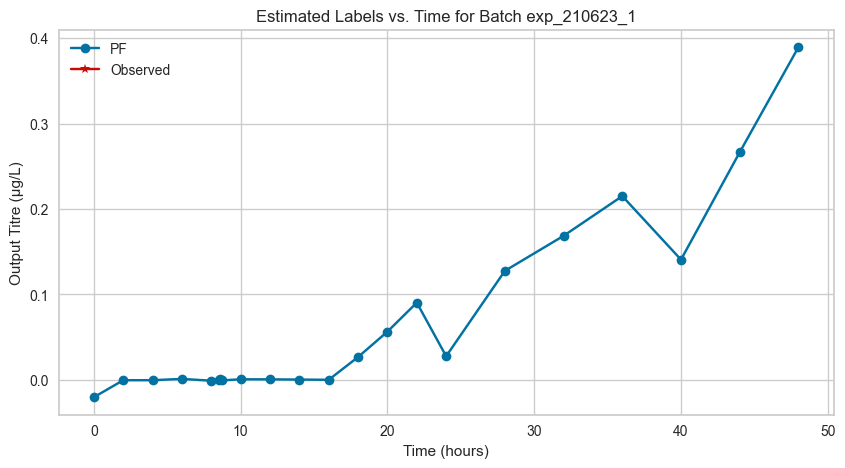

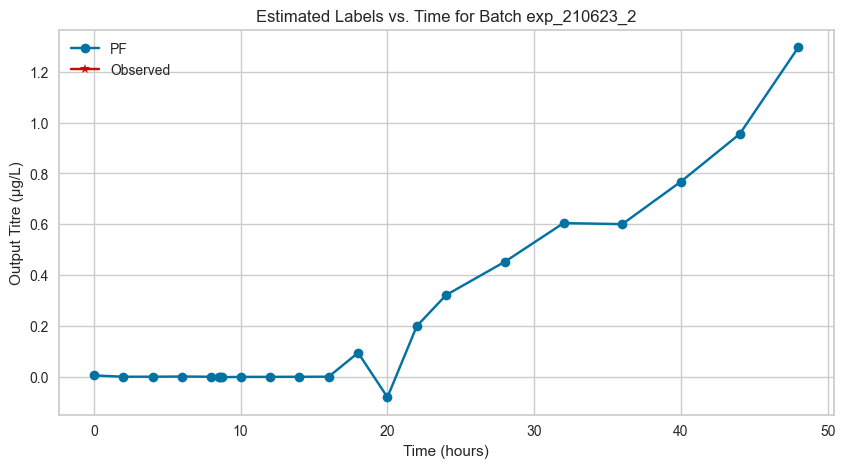

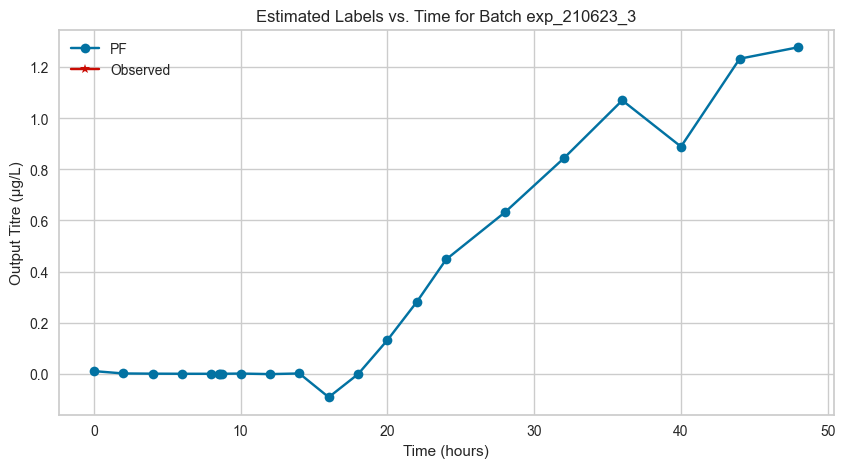

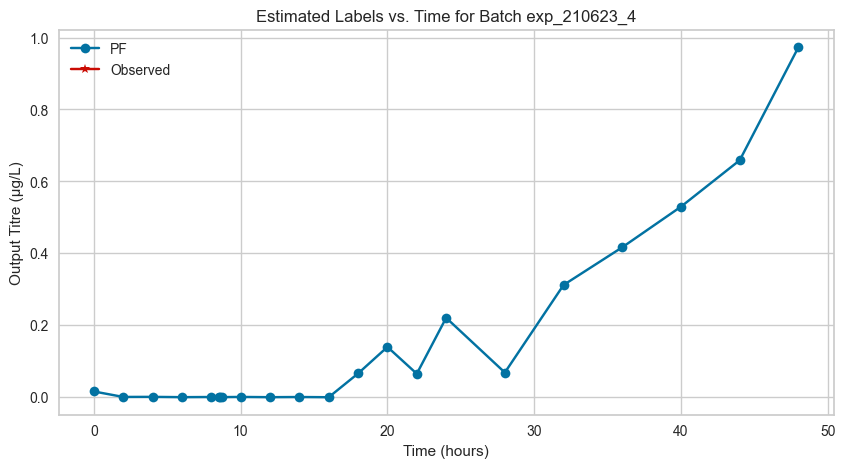

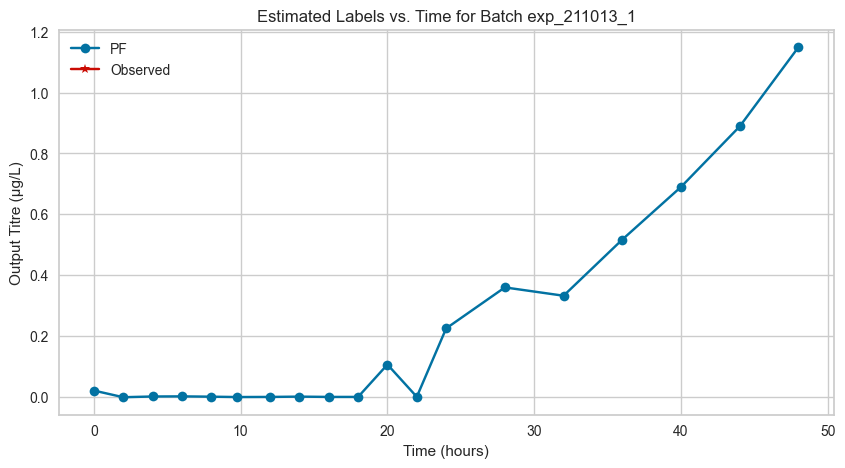

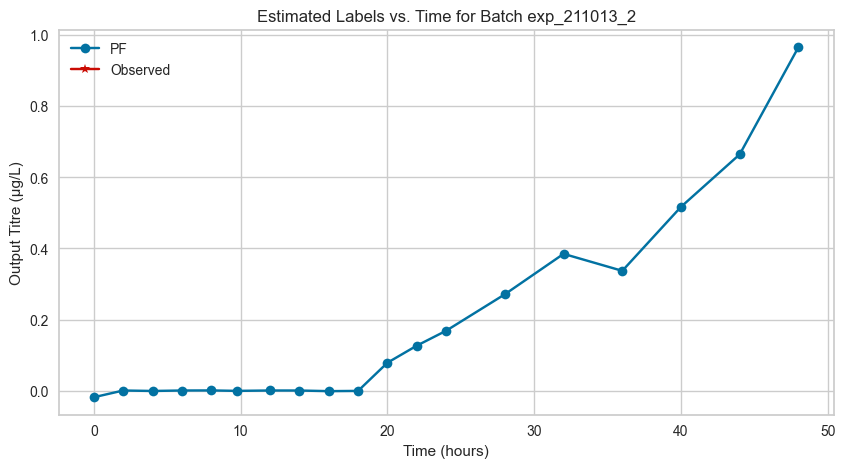

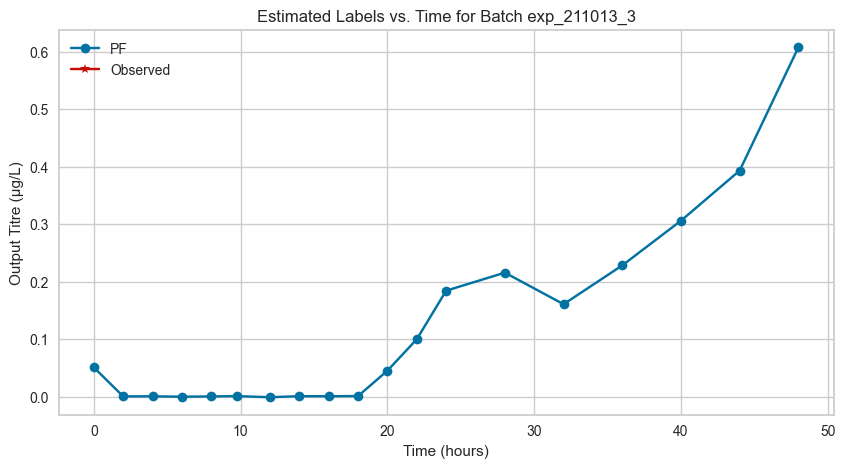

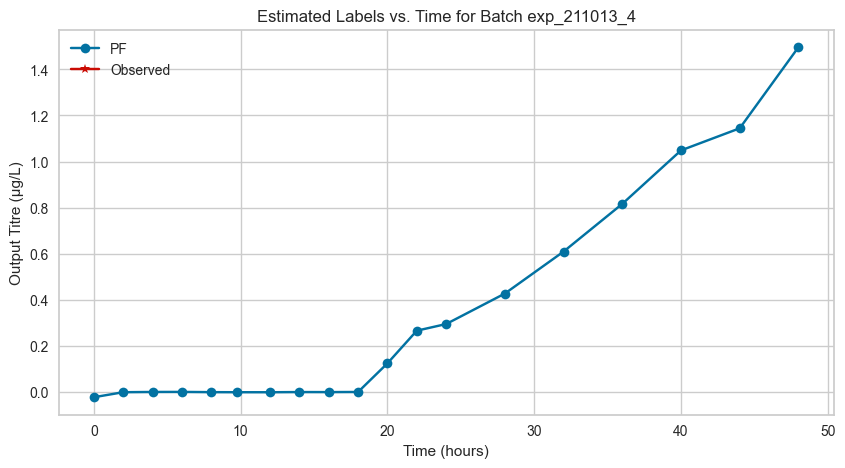

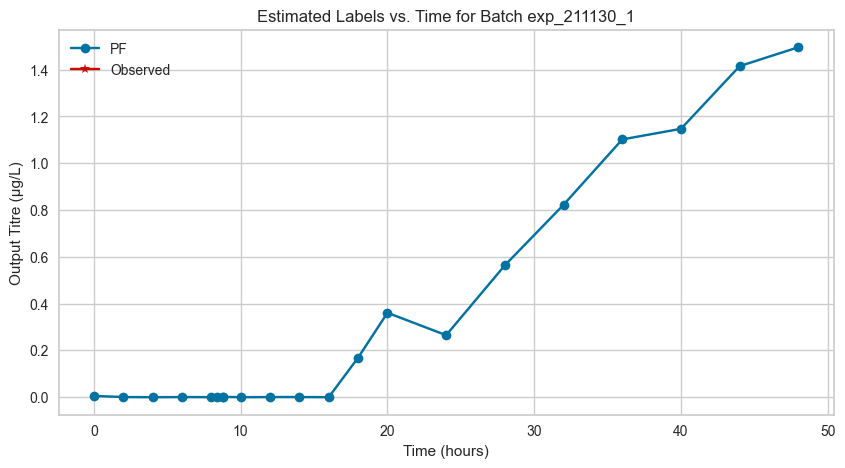

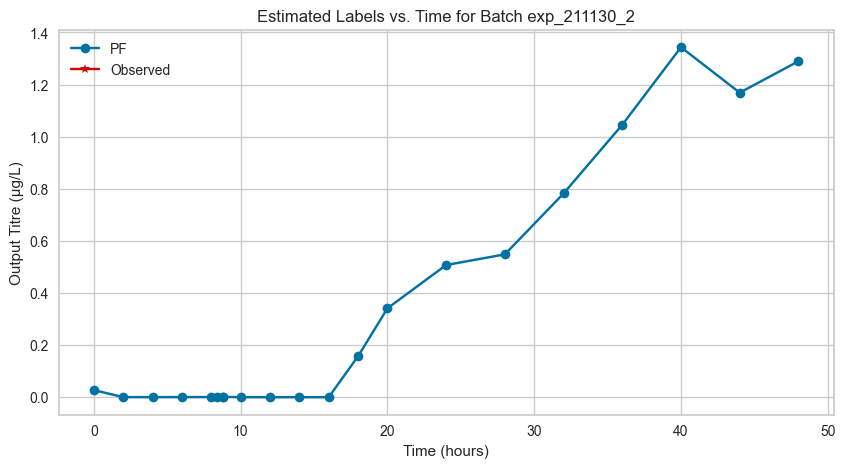

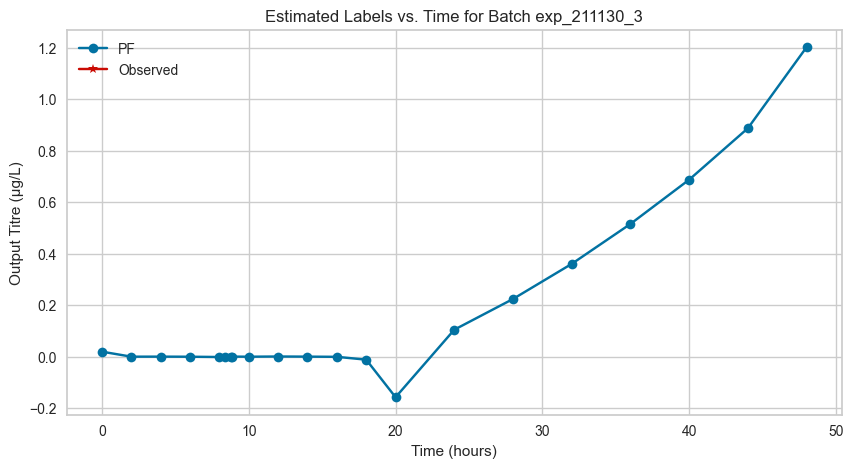

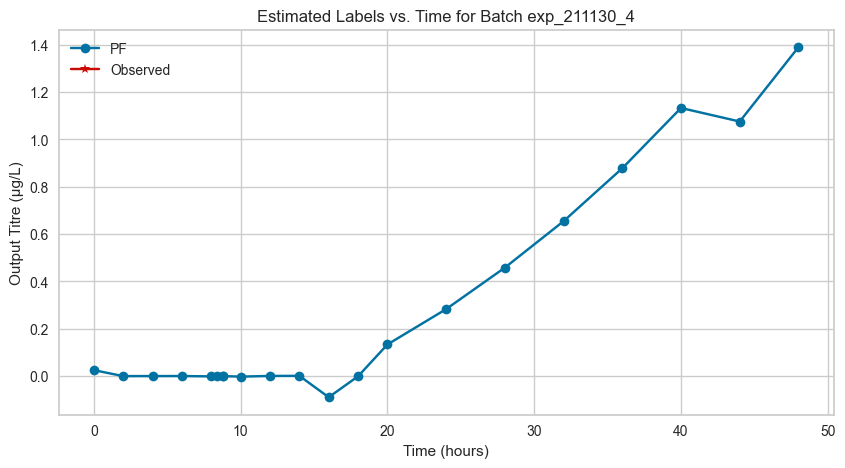

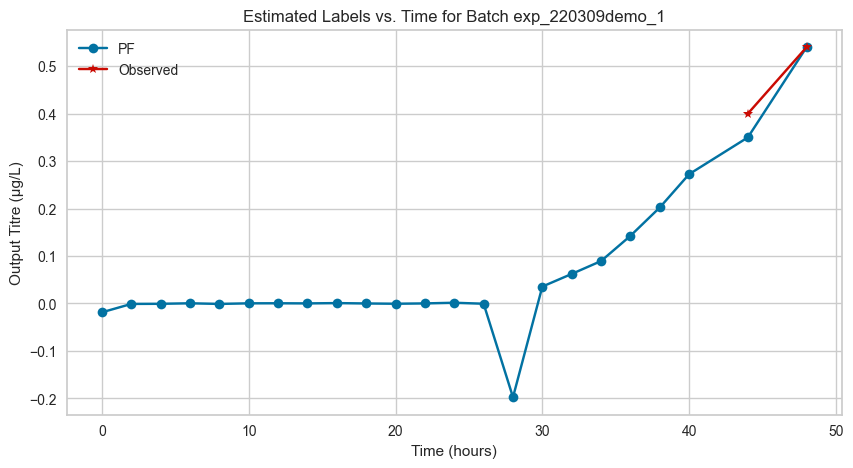

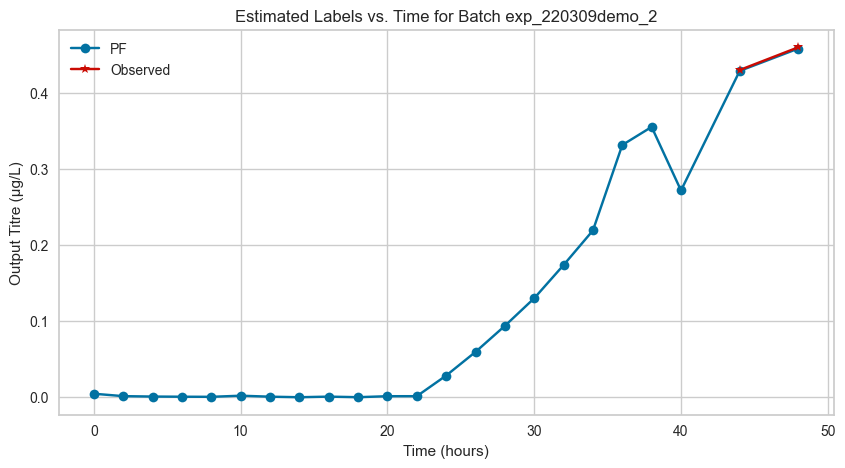

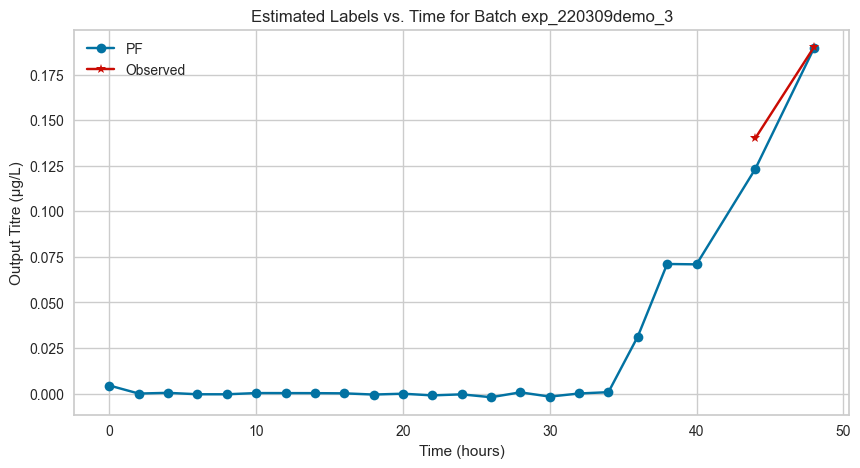

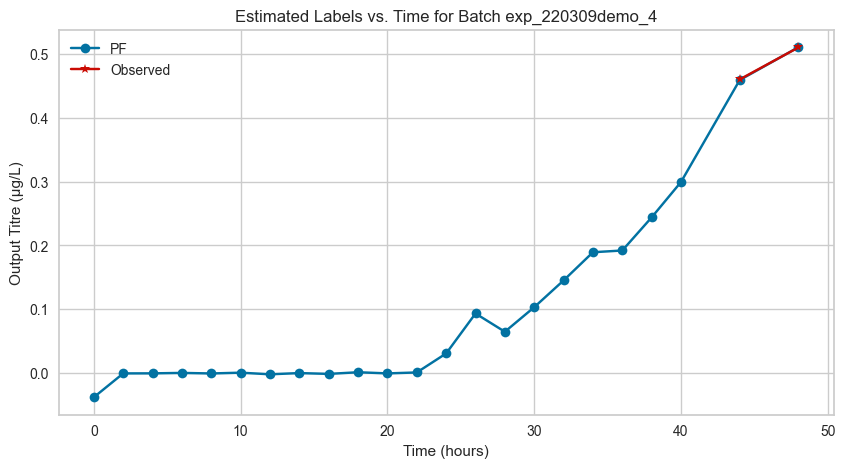

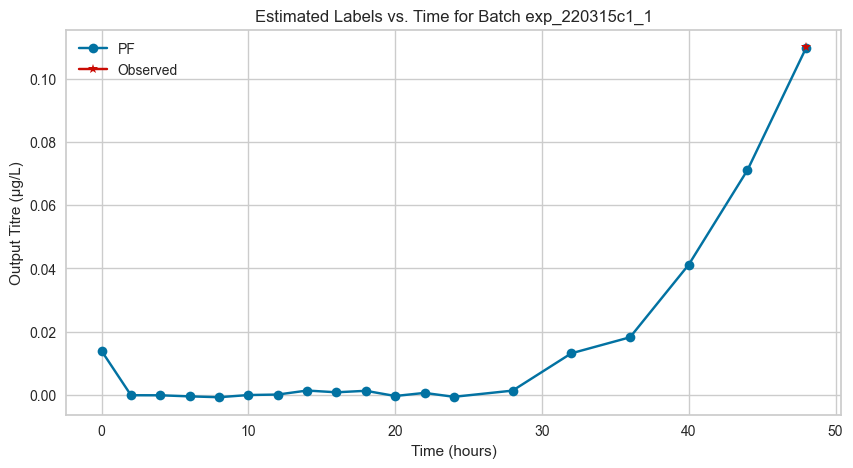

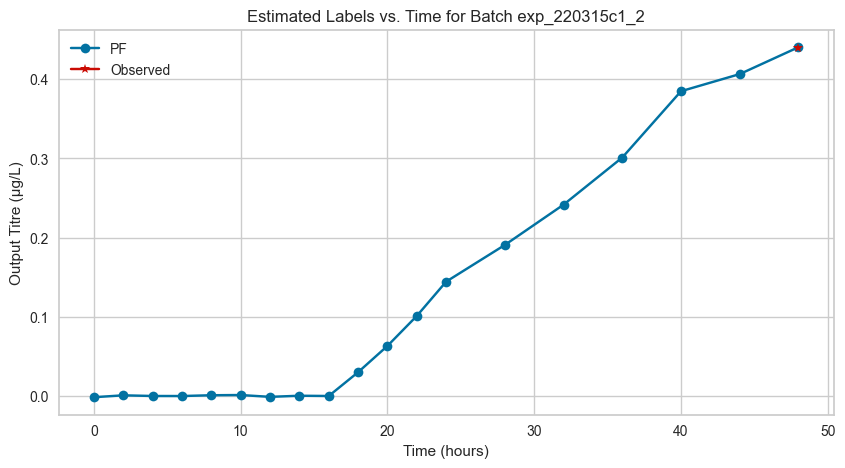

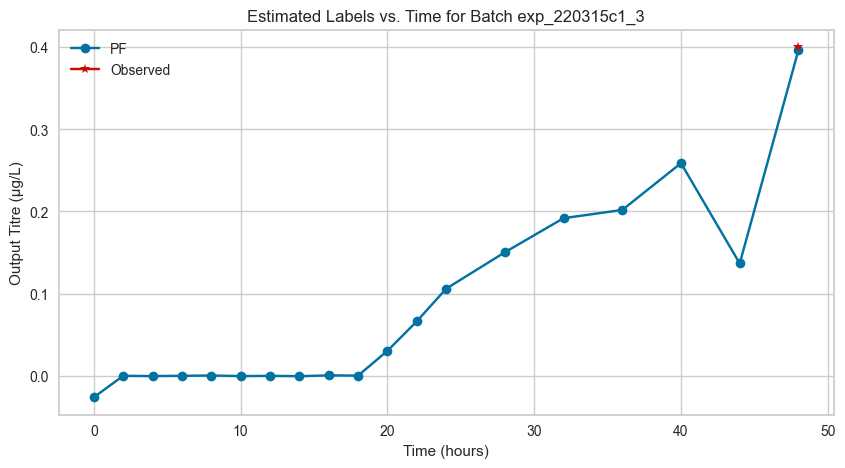

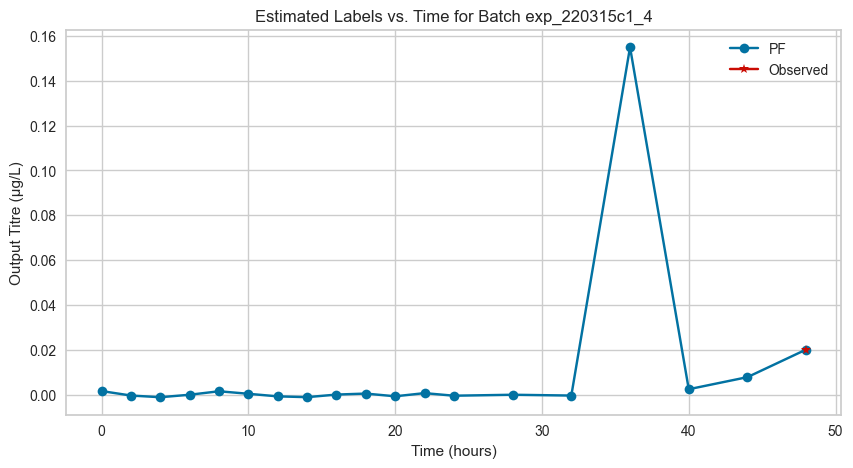

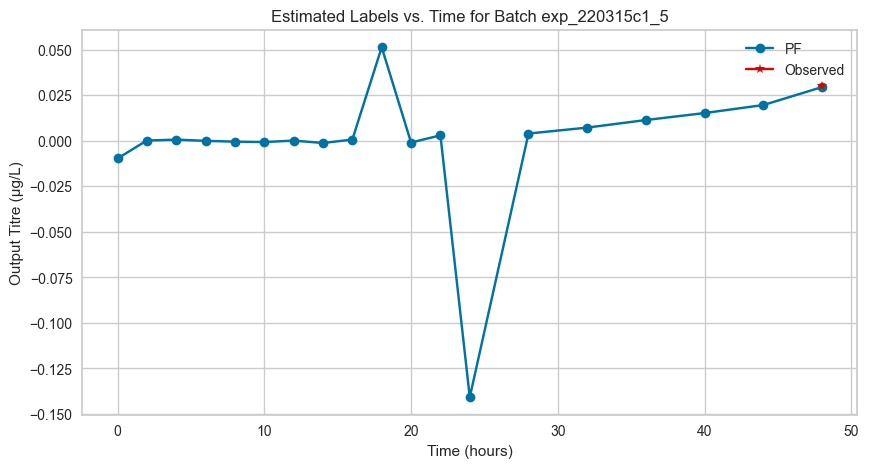

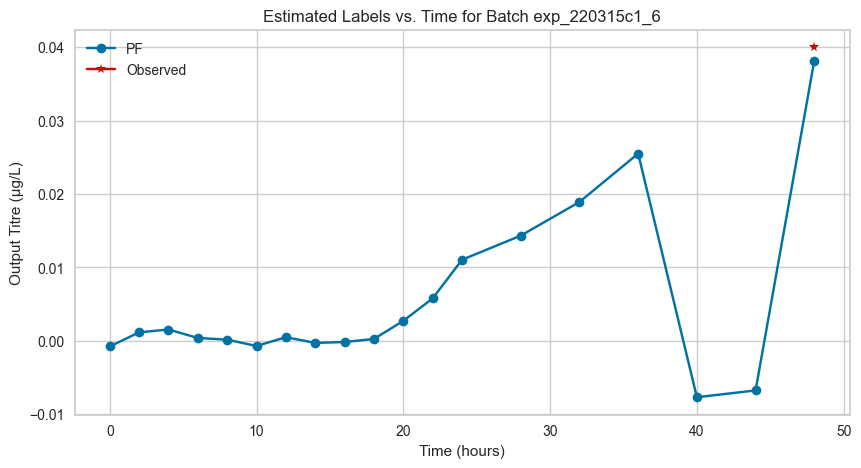

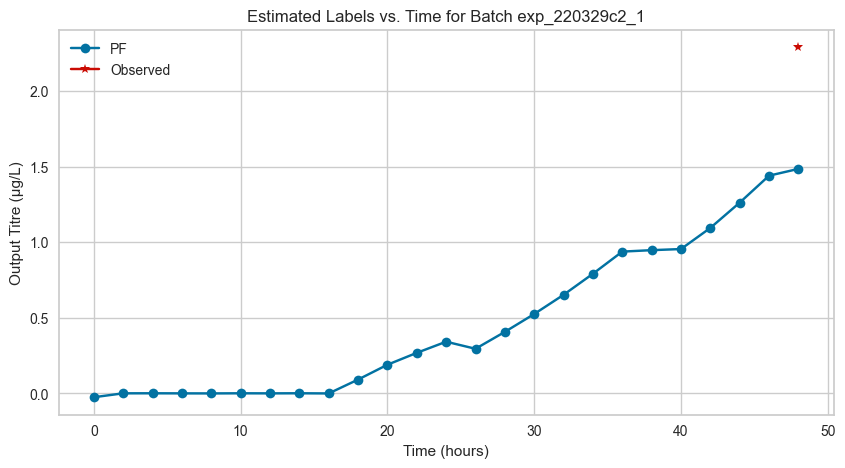

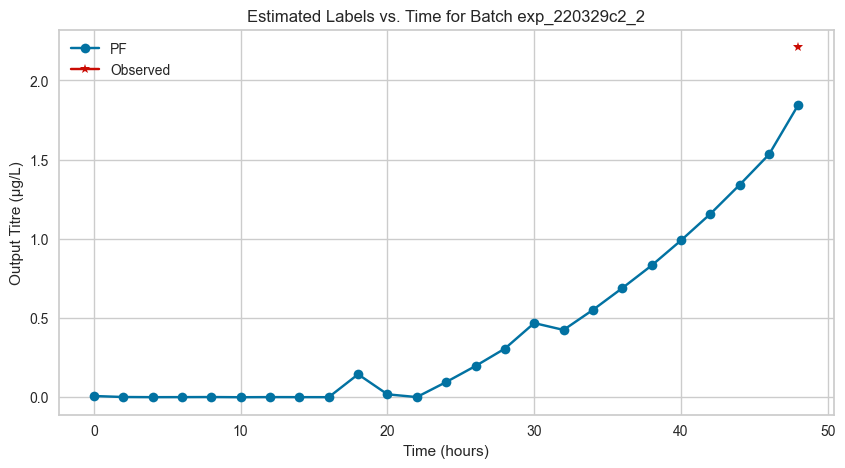

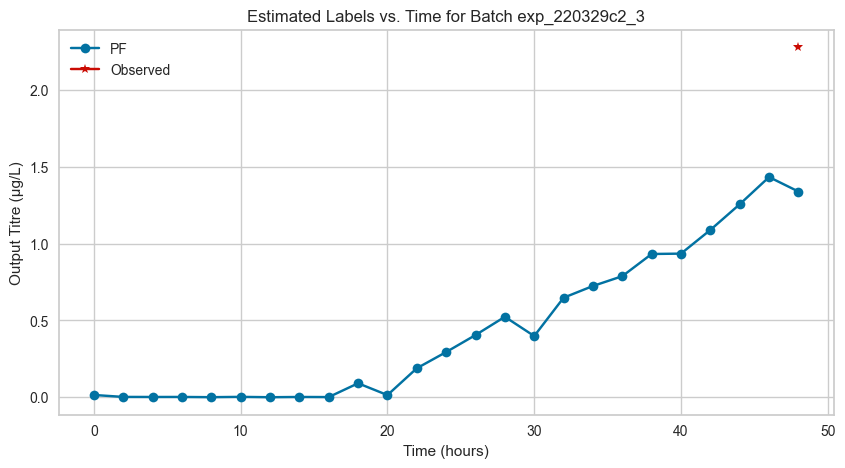

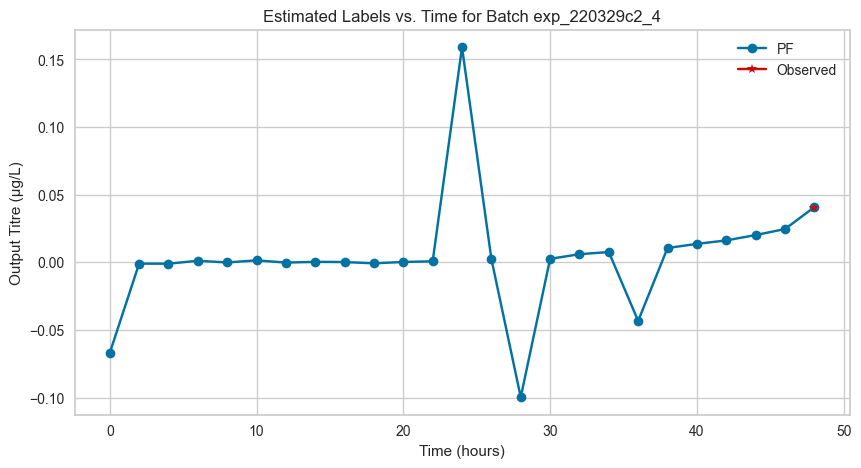

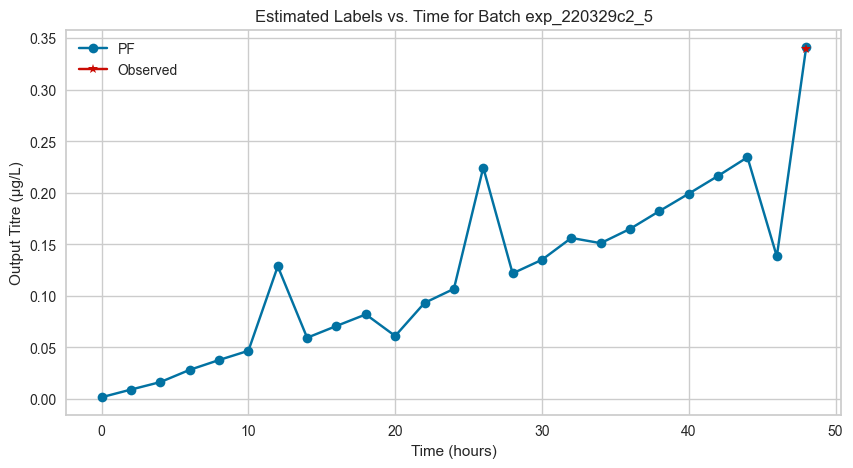

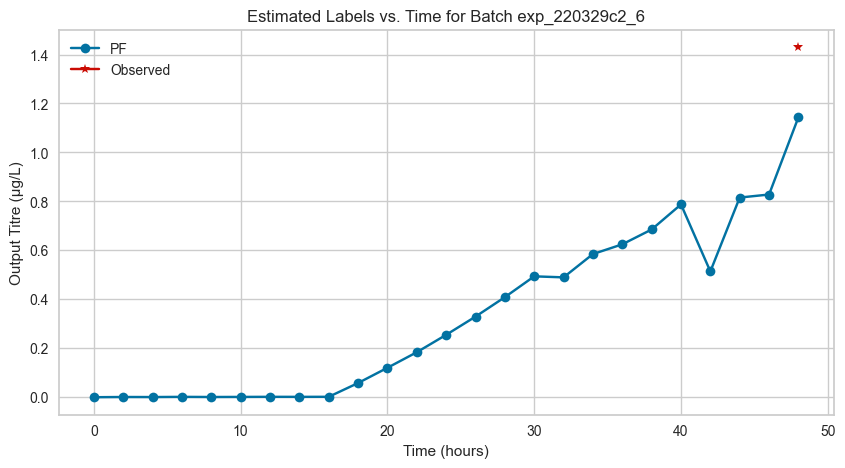

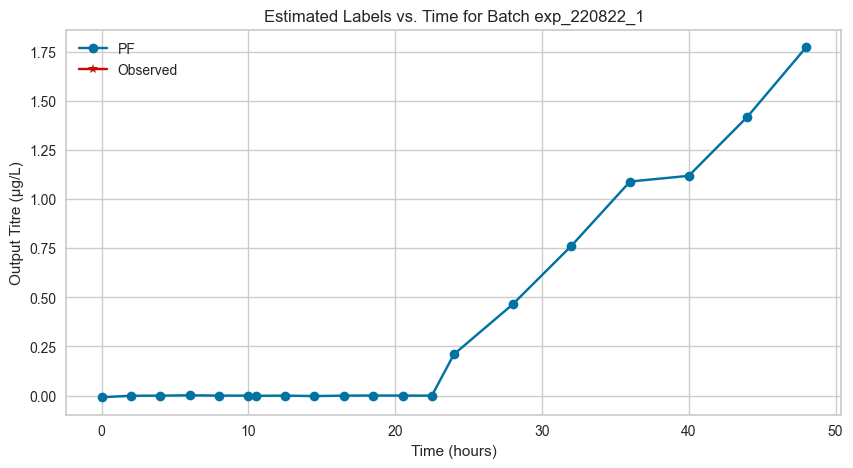

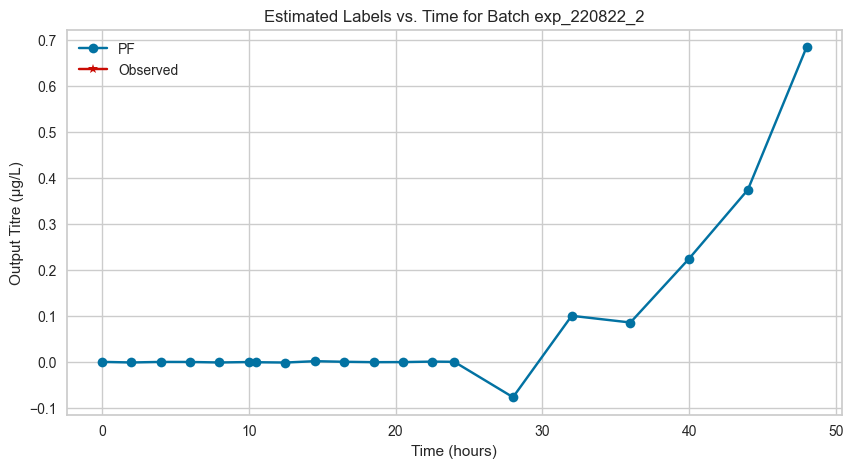

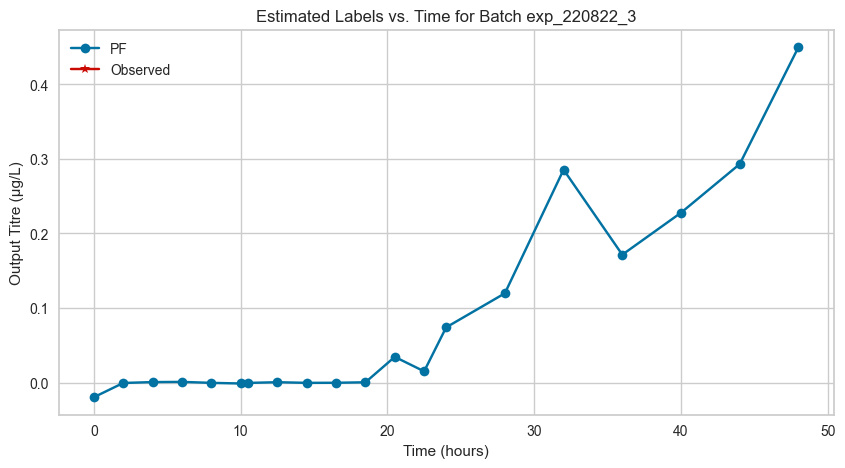

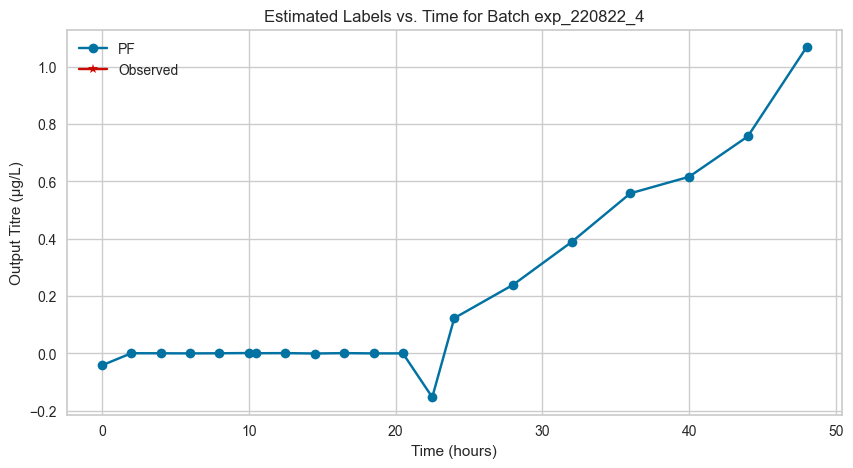

In [10]:
# Plotting each batch's estimated labels vs. time
for batch_data, batch in particle_results:
    plt.figure(figsize=(10, 5))
    plt.plot(batch_data['original_timepoint'], batch_data['output_titre_µgl'], marker='o', linestyle='-', color='b', label='PF')
    plt.plot(batch_data['original_timepoint'], batch_data['original_titer'], marker='*', linestyle='-', color='r', label='Observed') 
    plt.title(f'Estimated Labels vs. Time for Batch {batch}')
    plt.xlabel('Time (hours)')
    plt.ylabel('Output Titre (µg/L)')
    plt.grid(True)
    plt.legend()  # This adds the legend to the plot 
    plt.show()

> Saame with above but aplied Wienner filters to filter the predicted titer 

[1.e+03 1.e-01 1.e-02]


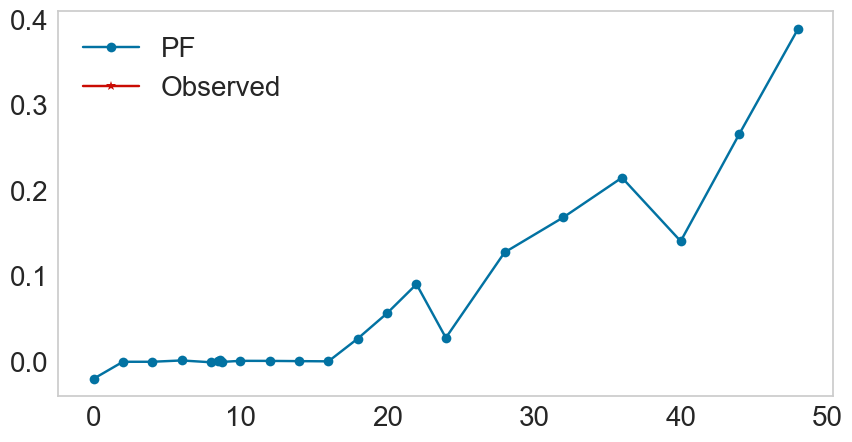

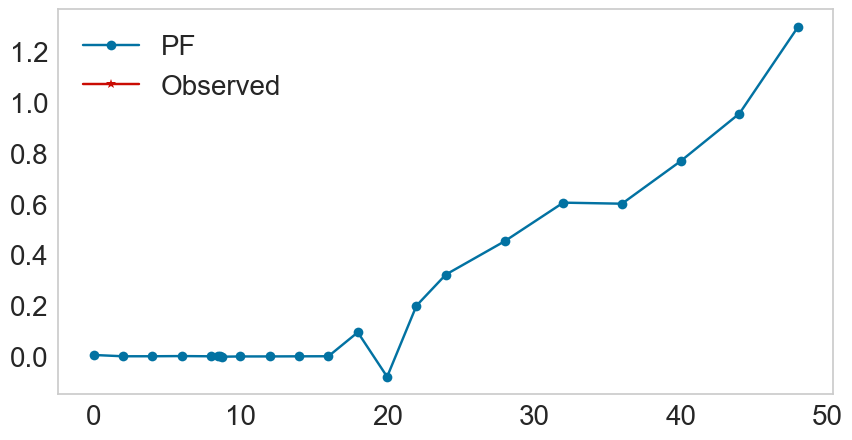

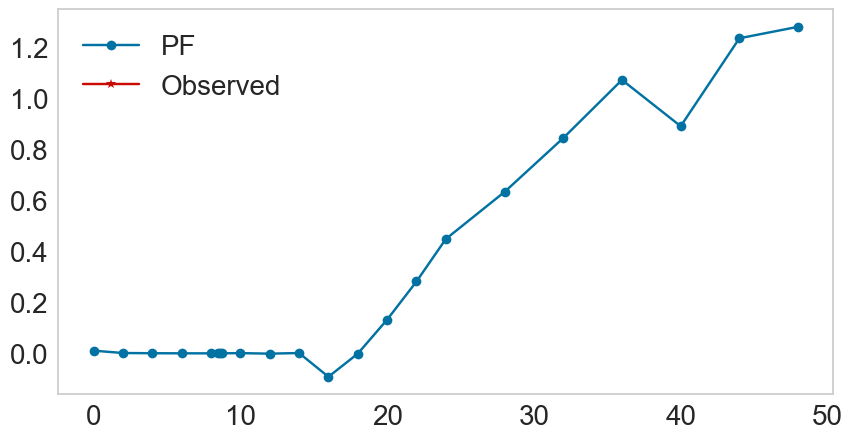

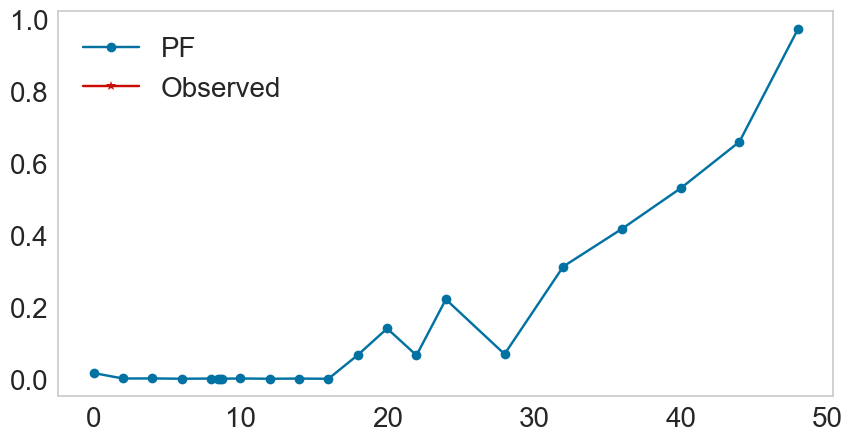

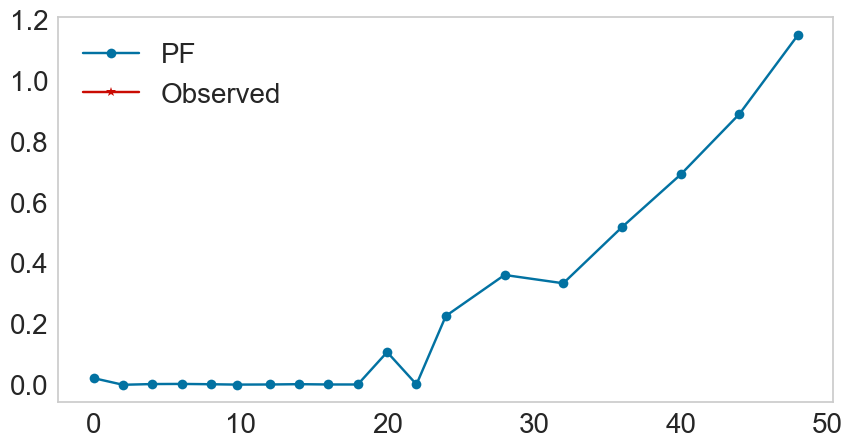

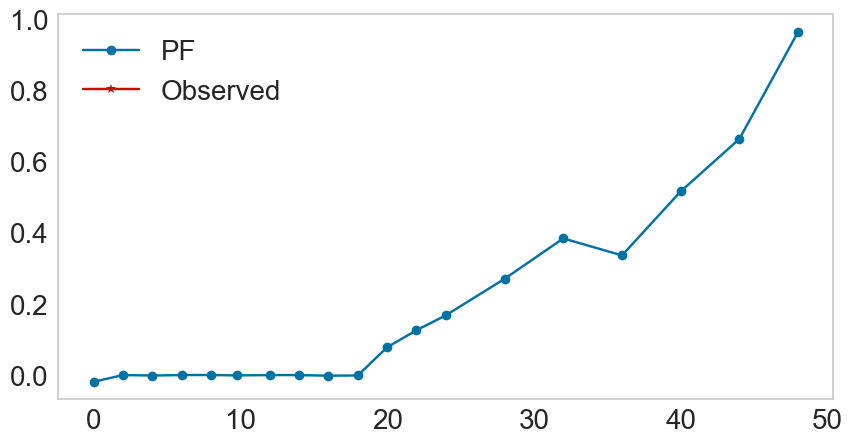

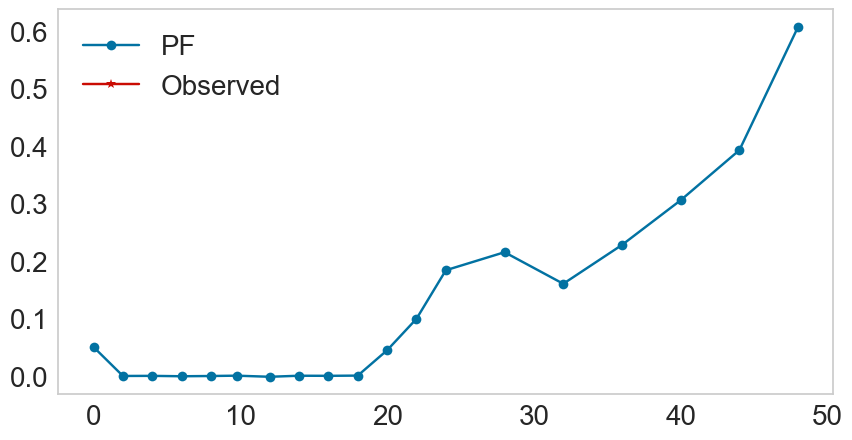

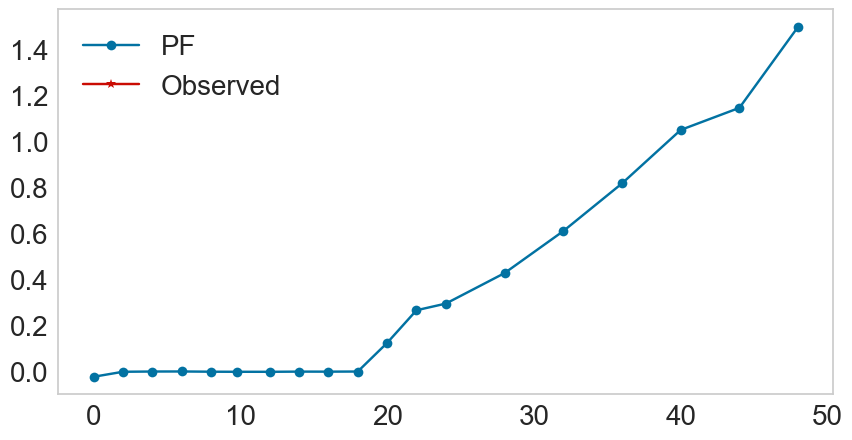

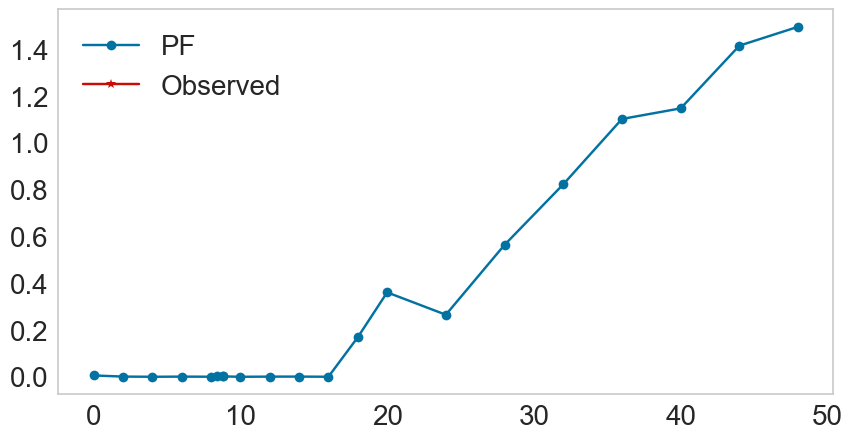

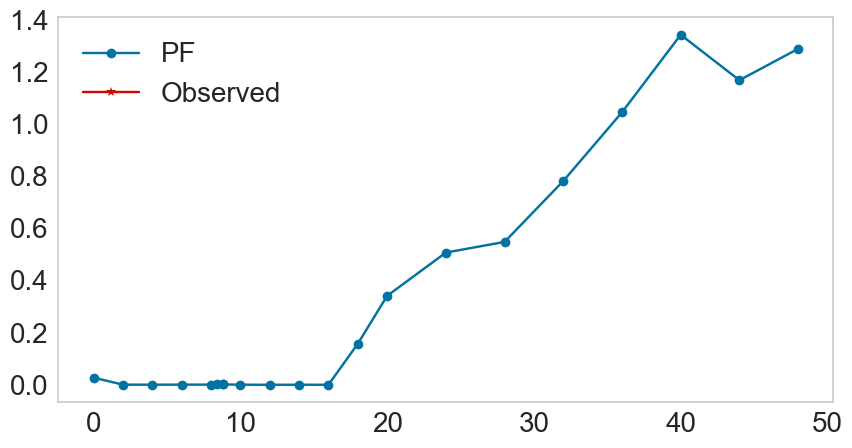

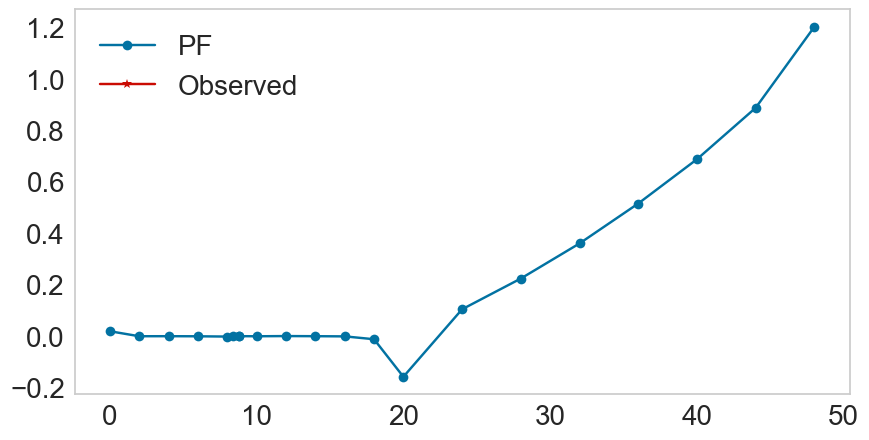

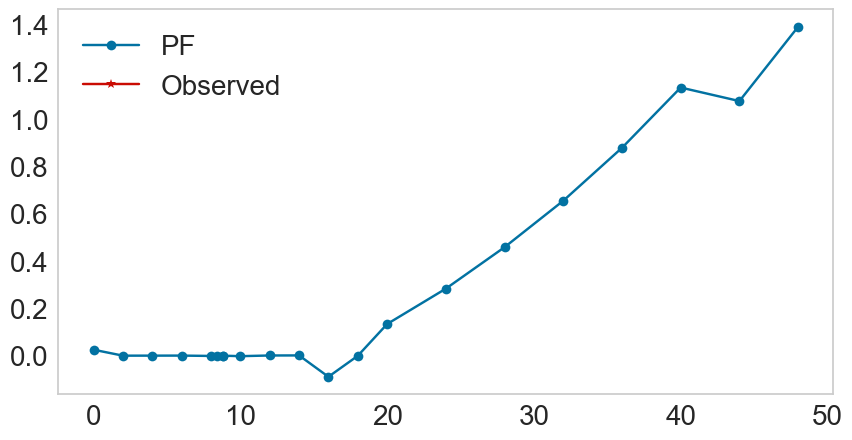

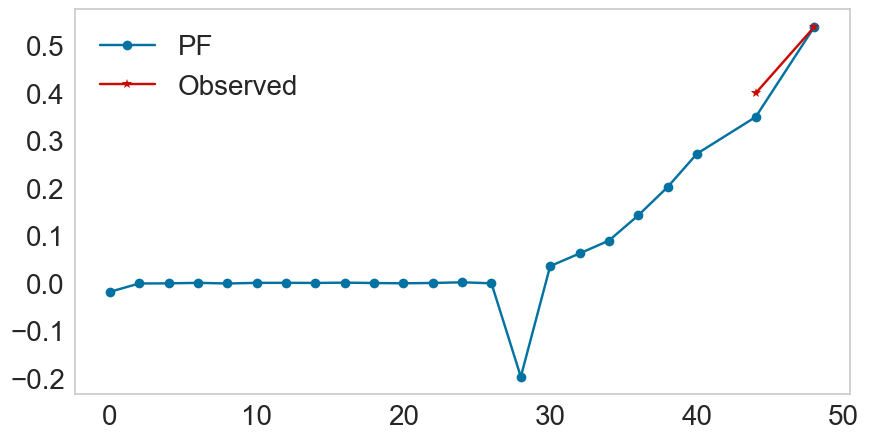

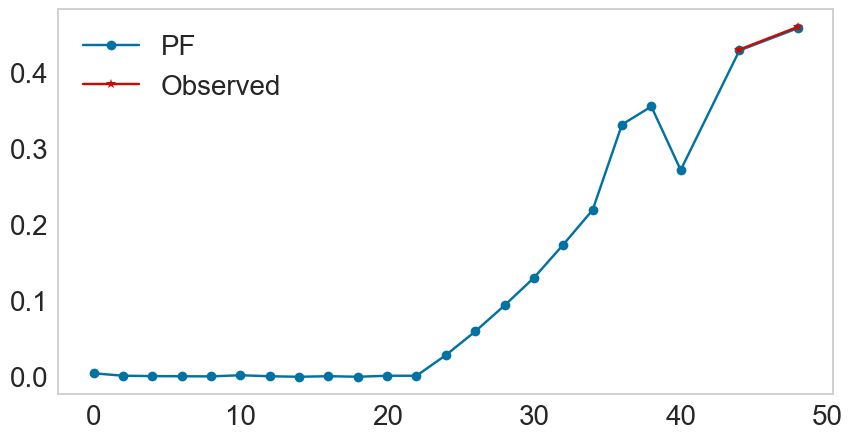

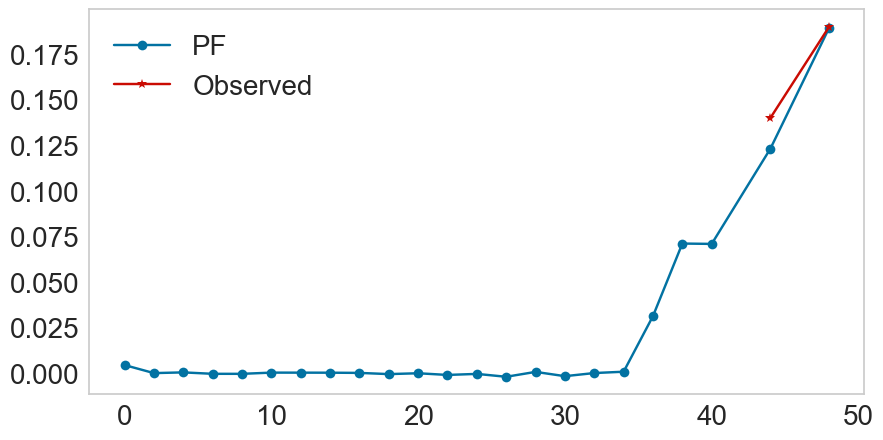

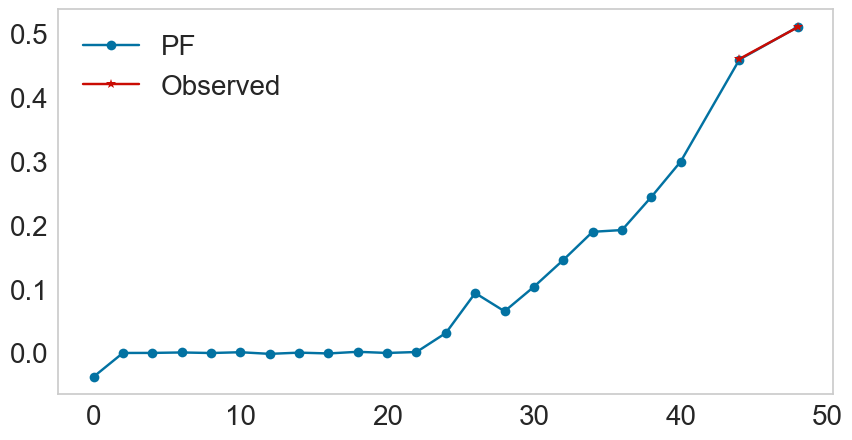

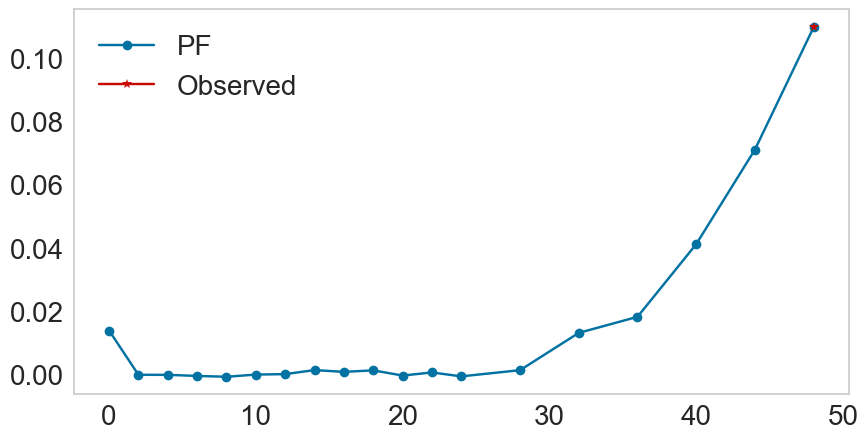

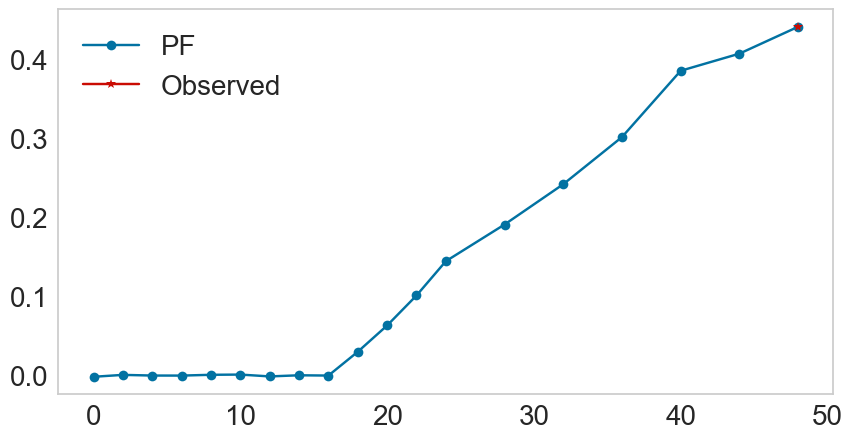

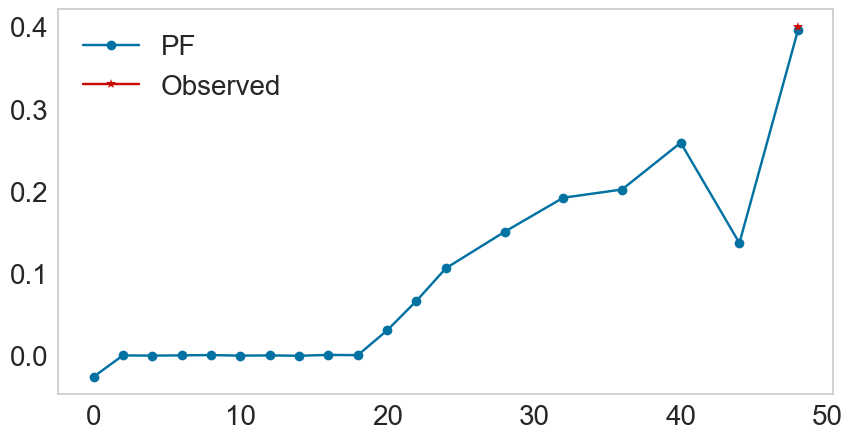

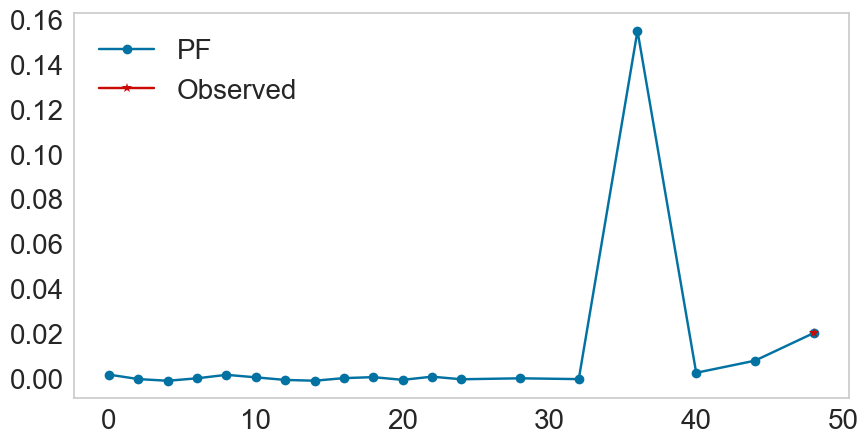

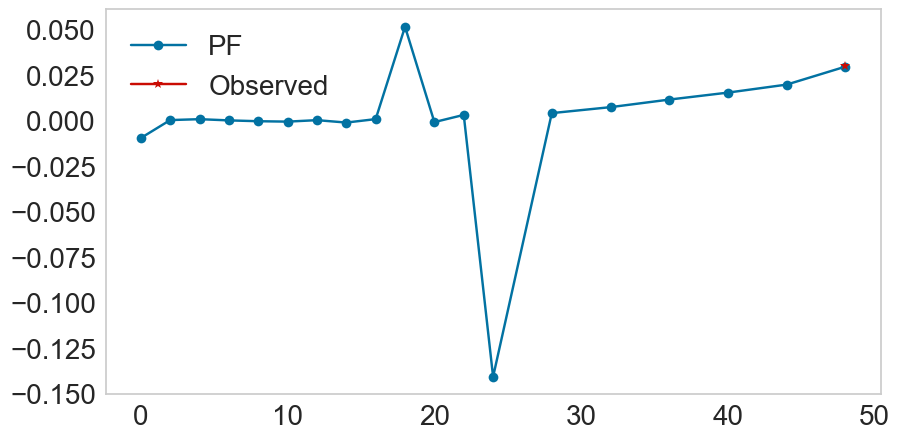

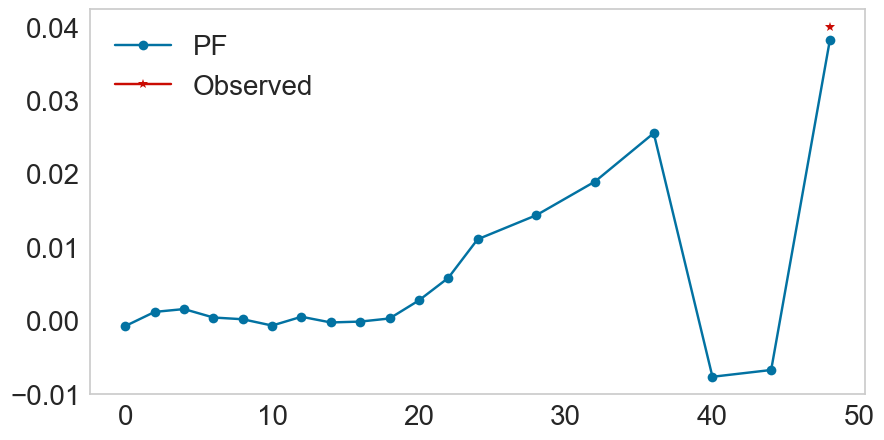

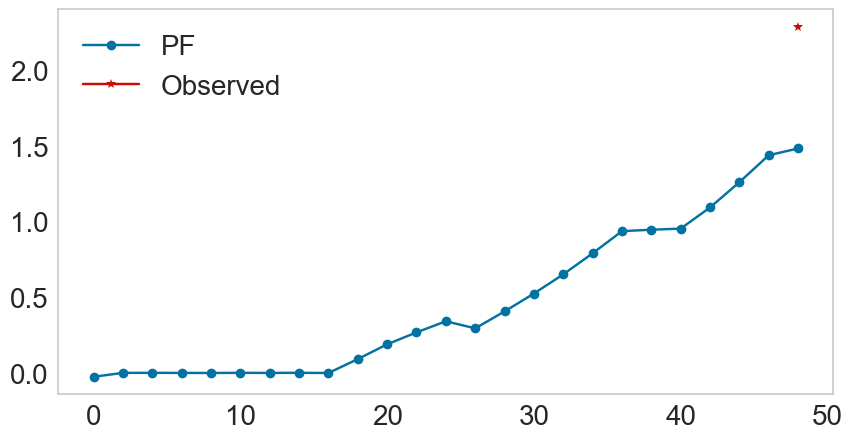

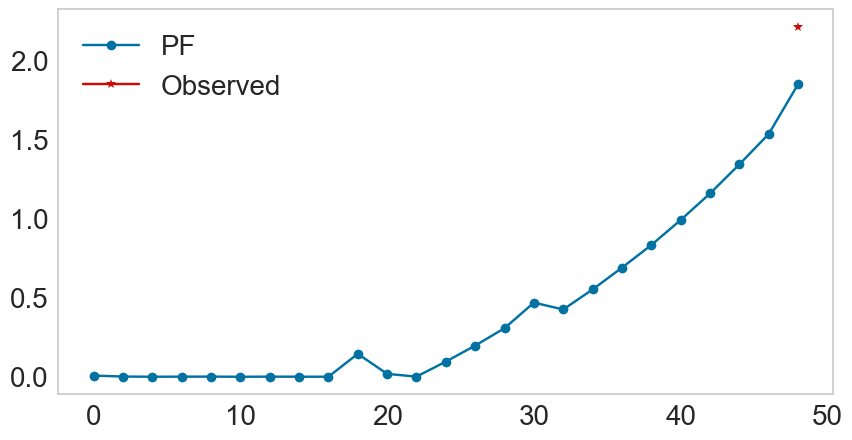

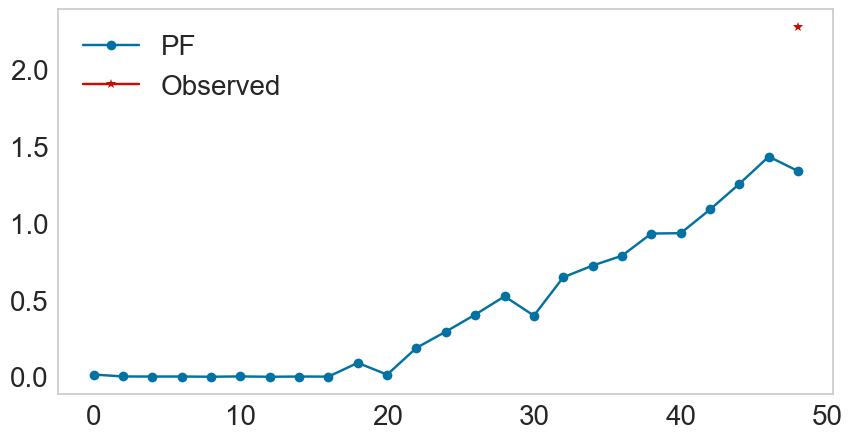

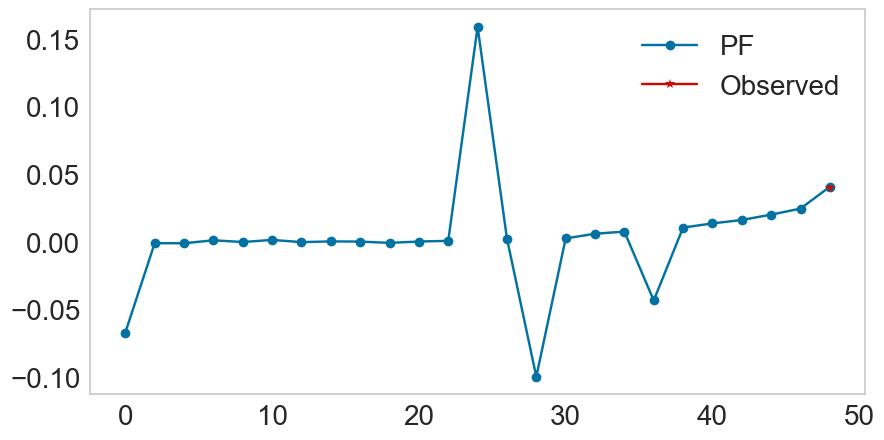

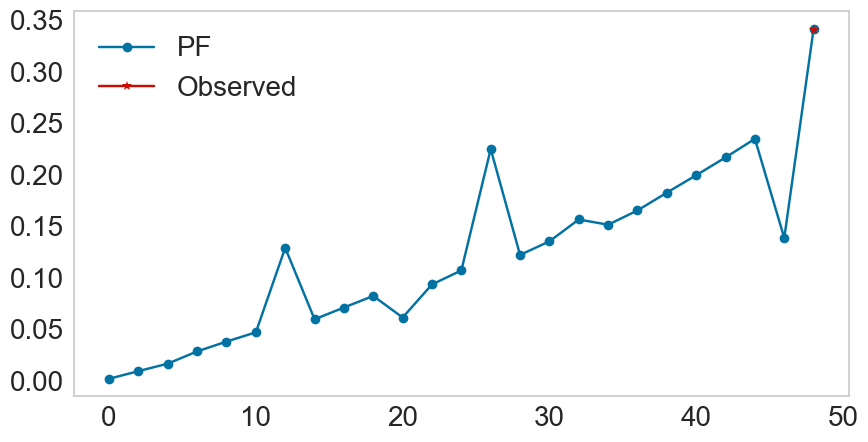

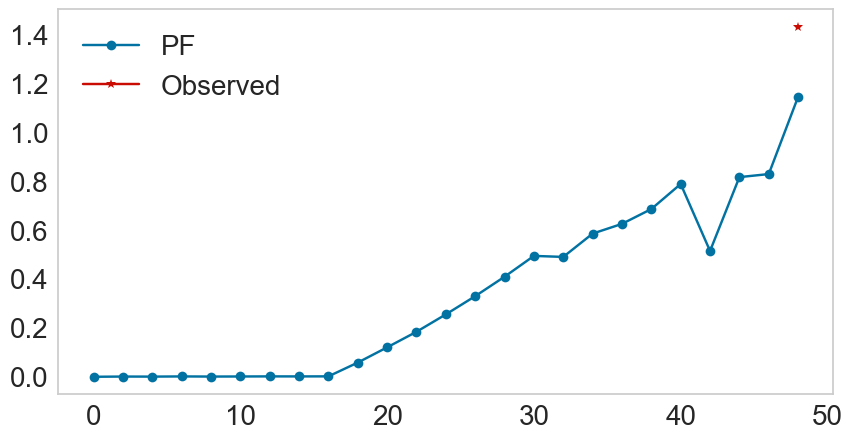

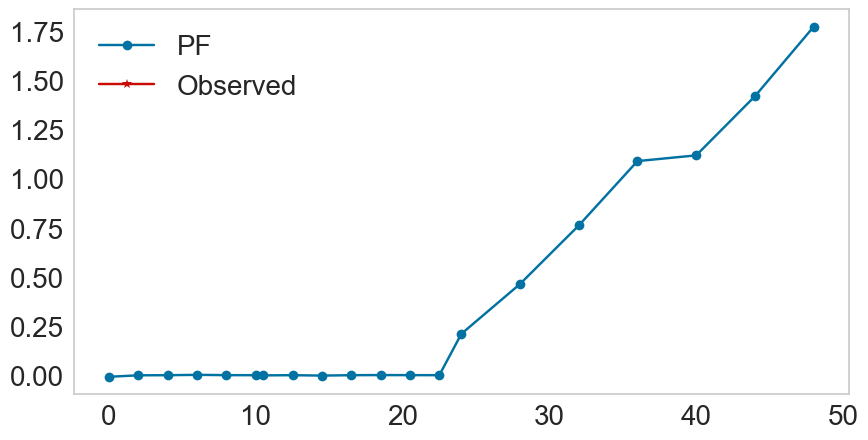

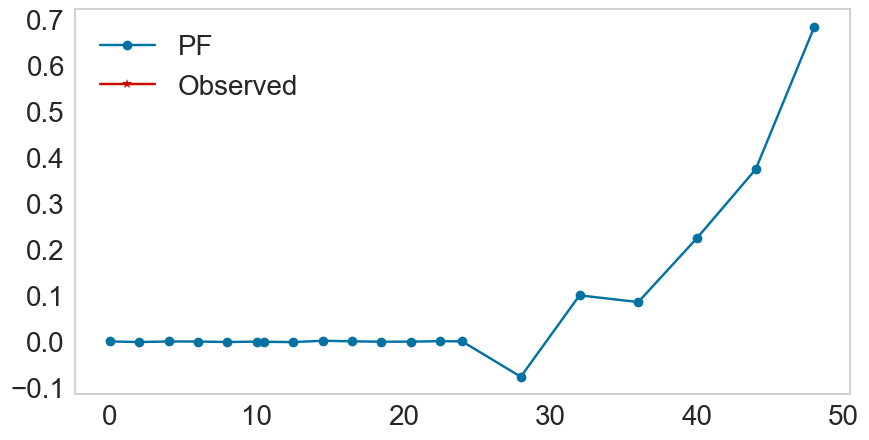

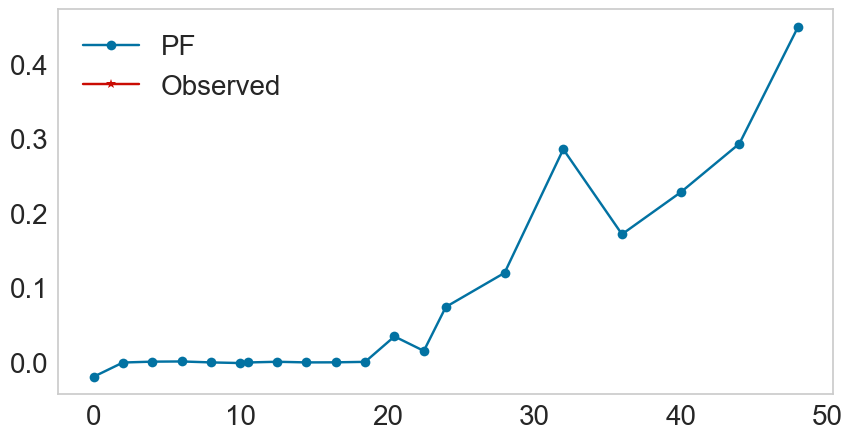

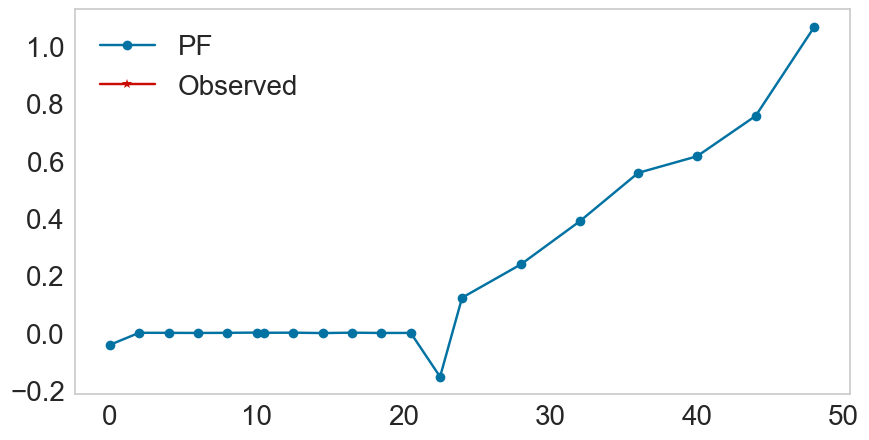

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.signal import wiener 

def create_particles(feature_ranges, num_particles):
    particles = np.empty((num_particles, len(feature_ranges)))
    for i, (min_val, max_val) in enumerate(feature_ranges):
        particles[:, i] = np.random.uniform(min_val, max_val, size=num_particles)
    return particles

def predict(particles, std_dev=1.0):
    """Add random noise to particles for prediction step."""
    noise = np.random.normal(0, std_dev, size=particles.shape)
    return particles + noise

def update(particles, weights, observed_value, model_function, measurement_std):
    """Update weights based on how particles' predicted values match the observed value."""
    predicted_values = model_function(particles)
    if np.isnan(observed_value):
        return weights  # Do not update weights if the observed value is NaN
    distances = np.abs(predicted_values - observed_value)
    weights *= norm.pdf(distances, scale=measurement_std)
    weights += 1.e-300  # avoid round-off to zero
    weights /= np.sum(weights)  # Normalize weights
    return weights

def estimate(particles, weights):
    return np.average(particles[:, -1], weights=weights)  # Estimating 'output_titre_µgl'

def resample(particles, weights):
    cumulative_sum = np.cumsum(weights)
    indices = np.searchsorted(cumulative_sum, np.random.random(len(weights)))
    return particles[indices], np.ones(len(weights)) / len(weights)

def model_function(particles):
    return particles[:, -1]  # Assuming the last column is 'output_titre_µgl'

# Apply Wiener filter
def apply_wiener_filter(data):
    filtered_data = wiener(data, mysize=None, noise=None)
    return filtered_data

def train_evaluate_particle_filter(dataset, num_particles=1000, std_dev=0.1, measurement_std=0.01):
    unique_batches = dataset['batch'].unique()
    
    feature_ranges = [(dataset[col].min(), dataset[col].max()) for col in dataset.columns if col not in ['output_titre_µgl', 'batch', 
                                                                                                         'original_titer', 'input_batch']]

    particle_results = []
    for batch in unique_batches:
        batch_data = dataset[dataset['batch'] == batch]

        labels = batch_data['original_titer'].to_numpy()
        labels_2 = batch_data['output_titre_µgl'].to_numpy()
        
        time_vector = batch_data['input_Timepoint (hr)'].to_numpy()
        
        batch_data = batch_data.drop(columns=['batch', 'original_titer', 'input_batch'], axis=1)
        
        particles = create_particles(feature_ranges, num_particles)
        weights = np.ones(num_particles) / num_particles

        estimated_titer = []
        for i in range(len(batch_data)):
            observed_value = batch_data.iloc[i]['output_titre_µgl']
            particles = predict(particles, std_dev)
            weights = update(particles, weights, observed_value, model_function, measurement_std)
            particles, weights = resample(particles, weights)
            estimated_titer.append(estimate(particles, weights))
        
        filtered_df = pd.DataFrame({
            'original_timepoint': time_vector,
            'original_titer': labels,
            'output_titre_µgl': estimated_titer,
            'output_titre_µgl_2': labels_2
        })
        particle_results.append((filtered_df, batch))
        
    return particle_results

def objective_function(params, dataset):
    num_particles, std_dev, measurement_std = params
    mse_list = []
    try:
        results = train_evaluate_particle_filter(dataset, int(num_particles), std_dev, measurement_std)
        for batch_data, _ in results:
            mse = mean_squared_error(batch_data['output_titre_µgl_2'], batch_data['output_titre_µgl'])
            mse_list.append(mse)
    except ValueError:
        pass  # Handle the exception by skipping this batch during optimization
    return np.mean(mse_list) if mse_list else np.inf

def optimize_hyperparameters(dataset):
    initial_guess = [1000, 0.1, 0.01]
    bounds = [(100, 2000), (0.01, 1.0), (0.001, 0.1)]
    
    result = minimize(objective_function, initial_guess, args=(dataset,), bounds=bounds, method='L-BFGS-B')
    best_params = result.x
    return best_params

def impute_and_filter(dataset):
    results = []



    # Optimize hyperparameters
    best_params = optimize_hyperparameters(dataset)
    print(best_params)
    num_particles, std_dev, measurement_std = best_params

    # Train and evaluate particle filter
    particle_results = train_evaluate_particle_filter(dataset, int(num_particles), std_dev, measurement_std)

    for batch_data, batch_name in particle_results:
        # Apply Wiener filter to smooth the imputed data
        filtered_titer = apply_wiener_filter(batch_data['output_titre_µgl'])

        # Store the results
        batch_data['filtered_titer'] = filtered_titer
        results.append((batch_data, batch_name))

    return results

# Example usage
# Assuming 'dataframes' is a dictionary loaded with the necessary data
results = impute_and_filter(dataset)

# Define the font size
font_size = 20

# Plotting results
for batch_data, batch_name in particle_results:
    plt.figure(figsize=(10, 5))
    plt.plot(batch_data['original_timepoint'], batch_data['output_titre_µgl'], marker='o', linestyle='-', color='b', label='PF')
    plt.plot(batch_data['original_timepoint'], batch_data['original_titer'], marker='*', linestyle='-', color='r', label='Observed') 
    # plt.title(f'Estimated Labels vs. Time for Batch {batch_name}', fontsize=font_size) 
    # plt.xlabel('Time (hours)')
    # plt.ylabel('Output Titre (µg/L)')
    plt.grid(False)
    plt.legend(fontsize=font_size)  # This adds the legend to the plot
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.savefig(f'titer/Results/Particle Filters/Escherichia/{batch_name}.png')
    plt.show()


In [12]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import norm 
# from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.metrics import mean_squared_error

# def create_particles(feature_ranges, num_particles):
#     particles = np.empty((num_particles, len(feature_ranges)))
#     for i, (min_val, max_val) in enumerate(feature_ranges):
#         particles[:, i] = np.random.uniform(min_val, max_val, size=num_particles)
#     return particles

# def predict(particles, std_dev=1.0):
#     """Add random noise to particles for prediction step."""
#     noise = np.random.normal(0, std_dev, size=particles.shape)
#     return particles + noise

# def update(particles, weights, observed_value, model_function, measurement_std):
#     """Update weights based on how particles' predicted values match the observed value."""
#     predicted_values = model_function(particles)
#     distances = np.abs(predicted_values - observed_value)
#     weights *= norm.pdf(distances, scale=measurement_std)
#     weights /= np.sum(weights)  # Normalize weights
#     return weights

# def estimate(particles, weights):
#     return np.average(particles[:, -1], weights=weights)  # Estimating 'output_titre_µgl'

# def resample(particles, weights):
#     cumulative_sum = np.cumsum(weights)
#     indices = np.searchsorted(cumulative_sum, np.random.random(len(weights)))
#     return particles[indices], np.ones(len(weights)) / len(weights)

# def model_function(particles):
#     # This function defines how we calculate the 'output_titre_µgl' based on the particles.
#     return particles[:, -1]  # Assuming the last column is 'output_titre_µgl'

# def train_evaluate_particle_filter(dataset, num_particles=1000, std_dev=0.1, measurement_std=0.01):
#     unique_batches = dataset['batch'].unique()
    
#     feature_ranges = [(dataset[col].min(), dataset[col].max()) for col in dataset.columns if col not in ['output_titre_µgl', 'batch', 
#                                                                                                          'original_titer', 'input_batch']]

#     particle_results = []
#     for batch in unique_batches:
#         batch_data = dataset[dataset['batch'] == batch]

#         labels = batch_data['original_titer'].to_numpy()
#         labels_2 = batch_data['output_titre_µgl'].to_numpy()
        
#         time_vector = batch_data['input_Timepoint (hr)'].to_numpy()
        
#         batch_data = batch_data.drop(columns=['batch', 'original_titer', 'input_batch'], axis=1)
        
#         particles = create_particles(feature_ranges, num_particles)
#         weights = np.ones(num_particles) / num_particles

#         estimated_titer = []
#         for i in range(len(batch_data)):
#             observed_value = batch_data.iloc[i]['output_titre_µgl']
#             particles = predict(particles, std_dev)
#             weights = update(particles, weights, observed_value, model_function, measurement_std)
#             particles, weights = resample(particles, weights)
#             estimated_titer.append(estimate(particles, weights))
        
#         filtered_df = pd.DataFrame({
#             'original_timepoint': time_vector,
#             'original_titer': labels,
#             'output_titre_µgl': estimated_titer,
#             'output_titre_µgl_2': labels_2
#         })
#         particle_results.append((filtered_df, batch))
        
#     return particle_results

# def objective_function(params, dataset):
#     num_particles, std_dev, measurement_std = params
#     results = train_evaluate_particle_filter(dataset, int(num_particles), std_dev, measurement_std)
#     mse_list = []
#     for batch_data, _ in results:
#         mse = mean_squared_error(batch_data['output_titre_µgl_2'], batch_data['output_titre_µgl'])
#         mse_list.append(mse)
#     return np.mean(mse_list)

# def optimize_hyperparameters(dataset):
#     from scipy.optimize import minimize
    
#     initial_guess = [1000, 0.1, 0.01]
#     bounds = [(100, 2000), (0.01, 1.0), (0.001, 0.1)]
    
#     result = minimize(objective_function, initial_guess, args=(dataset,), bounds=bounds, method='L-BFGS-B')
#     best_params = result.x
#     return best_params

# # Assuming 'dataset' is already loaded
# best_params = optimize_hyperparameters(dataset)
# num_particles, std_dev, measurement_std = best_params

# particle_results = train_evaluate_particle_filter(dataset, int(num_particles), std_dev, measurement_std)
